In [72]:
import pandas as pd
from IPython.display import display, HTML
%load_ext autoreload
%autoreload 2

import importlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
csv_file = open("uaScoresDataFrame.csv")
scores = pd.read_csv(csv_file)
scores = scores.drop('id', axis=1)
scores = scores.drop('Venture Capital', axis=1)

In [8]:
def check_zero(dataset):
    invalid_rows = []
    for element in dataset.columns.tolist():
        invalid = dataset[dataset[element] == 0.0]
        invalid_rows.append(invalid[['UA_Name','UA_Country']])
    df = pd.concat(invalid_rows).reset_index(drop=True).value_counts()
    return df
results = check_zero(scores).to_frame().reset_index().rename(columns={0:"number"})
print(results)

                       UA_Name               UA_Country  number
0                      Andorra                  Andorra       6
1                    Gibraltar                Gibraltar       5
2                      Managua                Nicaragua       3
3                     Tashkent               Uzbekistan       3
4                  Belize City                   Belize       3
5                       Panama                   Panama       3
6                    Palo Alto               California       2
7                       La Paz                  Bolivia       2
8                     Portland                    Maine       2
9                       Havana                     Cuba       2
10                     Fukuoka                    Japan       2
11                    San Juan              Puerto Rico       2
12                     Bozeman                  Montana       2
13                   Baltimore                 Maryland       2
14                    Valletta          

In [9]:
scores = scores[(scores != 0).all(1)]

In [10]:
weights_data = {
    'Housing' : 1.5,
    'Cost of Living' : 1.5,
    'Startups' : 0.5,
    'Business Freedom' : 0.8,
    'Safety' : 1.5,
    'Healthcare' : 1.5,
    'Education' : 0.5,
    'Travel Connectivity' : 1.5,
}

weights_vector = pd.Series(0.0, index=scores.columns[3:-1])
for i in range(len(weights_vector)):
    row_name = weights_vector.index[i]
    weights_vector[i] = weights_data.get(row_name, 1)

In [11]:
summable_values = list(scores)
if 'Naive Sum' in summable_values:
    summable_values.remove('Naive Sum')
weighted_scores = scores.copy()
weighted_scores = weighted_scores * weights_vector
scores['Naive Sum'] = weighted_scores[summable_values].sum(numeric_only=True, axis=1)

In [33]:
# scores['Naive Sum']
# better, worse

midpoint = scores['Naive Sum'].quantile()
scores['Label'] = ''
scores.loc[scores['Naive Sum'] < midpoint, 'Label'] = 'worse'
scores.loc[scores['Naive Sum'] >= midpoint, 'Label'] = 'better'

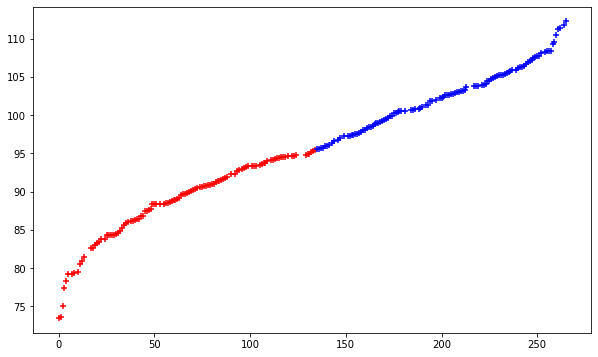

In [42]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
vals = scores['Naive Sum'].sort_values()
colors = np.where(vals >= midpoint, 'b', 'r')
ax.scatter(scores.index, vals, c=colors, marker='+')

In [48]:
from Modules.dataprocessing import ProcessingData

a, b = ProcessingData.prepare_data(scores)

preview_table = pd.concat([a.head(), b.head()])
display(preview_table)

,UA_Name,UA_Country,UA_Continent,Housing,Cost of Living,Startups,Travel Connectivity,Commute,Business Freedom,Safety,...,Education,Environmental Quality,Economy,Taxation,Internet Access,Leisure & Culture,Tolerance,Outdoors,Naive Sum,Label
0,Adelaide,Australia,Oceania,0.589944,0.410222,0.237389,0.117366,0.765279,0.916840,0.760411,...,0.503963,0.825857,0.590794,0.368848,0.383318,0.369833,0.766579,0.676846,0.566347,worse
1,Quebec,Canada,Europe,0.835278,0.559667,0.303833,0.074970,0.755795,0.856767,0.902905,...,0.534144,0.709004,0.562573,0.682120,0.263710,0.515167,0.864016,0.567604,0.809336,better
2,Brussels,Belgium,Europe,0.595000,0.386333,0.521278,0.728185,0.773792,0.844438,0.619130,...,0.668006,0.395419,0.435763,0.053301,0.753958,0.793778,0.603252,0.487421,0.732634,better
3,Los Angeles,California,North America,0.058611,0.395111,1.000000,0.351562,0.485543,0.802558,0.503841,...,0.882043,0.411590,0.645634,0.389725,0.515890,0.910667,0.661592,0.840441,0.430683,worse
4,Saskatoon,Canada,North America,0.684389,0.449111,0.234944,0.061769,0.844390,0.856767,0.611621,...,0.525893,0.759934,0.562573,0.682120,0.446306,0.000000,0.707387,0.000000,0.496402,worse
188,Nantes,France,Europe,0.746944,0.446778,0.261444,0.462166,0.876802,0.735190,0.726853,...,0.423895,0.709867,0.360959,0.142524,0.443667,0.372333,0.673223,0.292210,0.623389,better
189,Lille,France,Europe,0.725778,0.488778,0.250944,0.572824,0.252339,0.735190,0.646739,...,0.422701,0.354962,0.360959,0.142524,0.324346,0.456611,0.691188,0.241154,0.484625,worse
190,Tokyo,Japan,Asia,0.517444,0.270111,0.588556,0.801599,0.878446,0.775269,1.000000,...,0.703561,0.552499,0.301682,0.537322,0.439995,0.926889,0.690153,0.810238,0.955654,better
192,Shanghai,China,Asia,0.527111,0.686556,0.525056,0.663196,0.722836,0.154407,0.677526,...,0.564488,0.193739,0.594923,0.008164,0.187701,0.632611,0.147738,0.701937,0.328667,worse
193,Wroclaw,Poland,Europe,0.828000,0.826000,0.287333,0.167597,0.700961,0.404950,0.788078,...,0.397514,0.438437,0.429601,0.428155,0.546294,0.416611,0.289446,0.482309,0.522765,worse


In [71]:
import Modules.fuzzysys as fsys
from Modules.membership_functions import TriangularFunction
importlib.reload(fsys)

fuzzy = fsys.FuzzySystem()
fuzzy.add_antecedent('Housing', 'Bad', TriangularFunction(0, 0, 0.4))
fuzzy.add_antecedent('Housing', 'Mid', TriangularFunction(0.3, 0.4, 0.8))
fuzzy.add_antecedent('Housing', 'Good', TriangularFunction(0.7, 1, 1))

fuzzy.add_antecedent('Startups', 'Bad', TriangularFunction(0, 0, 0.3))
fuzzy.add_antecedent('Startups', 'Mid', TriangularFunction(0.2, 0.4, 0.6))
fuzzy.add_antecedent('Startups', 'Good', TriangularFunction(0.5, 0.8, 1))

for i in range(5):
    sample = a.iloc[i].to_dict()
    fuzzified_sample = fuzzy.fuzzify(sample)
    print(f'{sample["UA_Name"]} -> {fuzzified_sample}')

Adelaide -> {'Housing': 'Mid', 'Startups': 'Bad'}
Quebec -> {'Housing': 'Good', 'Startups': 'Mid'}
Brussels -> {'Housing': 'Mid', 'Startups': 'Mid'}
Los Angeles -> {'Housing': 'Bad', 'Startups': 'Bad'}
Saskatoon -> {'Housing': 'Mid', 'Startups': 'Bad'}


In [ ]:
import Modules.fuzzysys as fsys
from Modules.membership_functions import TrapezoidalFunction
importlib.reload(fsys)

fuzzy = fsys.FuzzySystem()
fuzzy.add_antecedent('Housing', 'Bad', TrapezoidalFunction(0, 0.2, 0.4, 0.6))
fuzzy.add_antecedent('Housing', 'Mid', TrapezoidalFunction(0.1, 0.3, 0.5, 0.7))
fuzzy.add_antecedent('Housing', 'Good', TrapezoidalFunction(0.3, 0.5, 0.7, 1))

fuzzy.add_antecedent('Startups', 'Bad', TrapezoidalFunction(0, 0.3, 0.6, 0.9))
fuzzy.add_antecedent('Startups', 'Mid', TrapezoidalFunction(0.1, 0.4, 0.7, 1))
fuzzy.add_antecedent('Startups', 'Good', TrapezoidalFunction(0.05, 0.25, 0.45, 0.65))

for i in range(5):
    sample = a.iloc[i].to_dict()
    fuzzified_sample = fuzzy.fuzzify(sample)
    print(f'{sample["UA_Name"]} -> {fuzzified_sample}')